# Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.metrics import f1_score

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

%matplotlib inline

# EDA

In [ ]:
data_dir = '/kaggle/input/journey-springfield/'
train_path = Path(data_dir + 'train/simpsons_dataset')
test_path = Path(data_dir + 'testset/testset')

In [ ]:
train_files = sorted(list(train_path.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]
test_files = sorted(list(test_path.rglob('*.jpg')))

data = pd.Series(train_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
disco_stu,8
troy_mcclure,8
miss_hoover,17
fat_tony,27
gil,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


Виден сильный дисбаланс классов. Нужно будет использовать аугментацию для выравнивания распределения

# Augmentation


In [ ]:
dataset = datasets.ImageFolder(root=train_path)

train_indices, val_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=dataset.targets,
    random_state=42
)

In [ ]:
train_targets = [dataset.targets[i] for i in train_indices]
class_counts = Counter(train_targets)
max_count = max(class_counts.values())

indices_per_class = {cls: [] for cls in class_counts.keys()}
for idx in train_indices:
    label = dataset.targets[idx]
    indices_per_class[label].append(idx)

balanced_train_indices = []
for cls, indices in indices_per_class.items():
    balanced_train_indices.extend(indices)
    num_to_add = max_count - len(indices)
    if num_to_add > 0:
        additional_indices = np.random.choice(indices, num_to_add, replace=True)
        balanced_train_indices.extend(additional_indices)


In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.Compose([
            transforms.Resize(size=300),
            transforms.CenterCrop(size=300),
            transforms.RandomCrop(250)
        ]),
        transforms.RandomRotation(degrees=(-25, 25)),
        transforms.RandomHorizontalFlip(p=1),
    ]),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label


train_dataset = CustomDataset(dataset, balanced_train_indices, transform=train_transforms)
val_dataset = CustomDataset(dataset, val_indices, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device = 'cuda:0'
else:
    print('CUDA is not available.  Training on CPU ...')
    device = 'cpu'

CUDA is available!  Training on GPU ...


# Create Model

In [ ]:
class SimpsonClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SimpsonClassifier, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 11, kernel_size=3),
            nn.BatchNorm2d(11),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(11, 15, kernel_size=3),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(32, 10, kernel_size=3),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(10 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [ ]:
n_classes = len(np.unique(train_labels))
model = SimpsonClassifier(n_classes).to(device)

loss = torch.nn.CrossEntropyLoss()

# Train & Test

In [ ]:
def fit(model, criterion, train_dataloader, valid_dataloader, max_epochs, lr=0.0003, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    metrics = {"train": {"accuracy": [], "f1": [], "loss": []},
               "valid": {"accuracy": [], "f1": [], "loss": []}}

    best_f1 = 0
    patience = 5
    trigger_times = 0

    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        for phase, dataloader in loaders.items():
            if phase == "train":
                model.train()
            else:
                model.eval()
            epoch_correct = 0
            epoch_all = 0
            running_loss = 0.0
            all_preds = []
            all_labels = []

            with tqdm(dataloader, unit="batch") as tepoch:
                tepoch.set_description(f"{phase.capitalize()} Phase")
                for x_batch, y_batch in tepoch:
                    x_batch = x_batch.to(device, non_blocking=True)
                    y_batch = y_batch.to(device, non_blocking=True)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == "train"):
                        outp = model(x_batch)
                        loss = criterion(outp, y_batch)

                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    preds = outp.argmax(dim=-1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(y_batch.cpu().numpy())

                    correct = (preds == y_batch).sum().item()
                    epoch_correct += correct
                    epoch_all += y_batch.size(0)
                    running_loss += loss.item() * x_batch.size(0)

                    tepoch.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloader.dataset)
            accuracy = epoch_correct / epoch_all
            f1 = f1_score(all_labels, all_preds, average="weighted")

            metrics[phase]["accuracy"].append(accuracy)
            metrics[phase]["f1"].append(f1)
            metrics[phase]["loss"].append(epoch_loss)

            print(f"{phase.capitalize()} Phase - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

            if phase == "valid":
                if f1 > best_f1:
                    best_f1 = f1
                    trigger_times = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print('Early stopping!')
                        return metrics
        scheduler.step()
    return metrics


In [ ]:
fit(model, loss, train_loader, val_loader, 50, device=device)

Epoch 1/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.5181, Accuracy: 0.8591, F1 Score: 0.8558


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 1.1120, Accuracy: 0.6905, F1 Score: 0.6913
Epoch 2/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.4258, Accuracy: 0.8833, F1 Score: 0.8810


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 1.0629, Accuracy: 0.7067, F1 Score: 0.7113
Epoch 3/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.3608, Accuracy: 0.9003, F1 Score: 0.8986


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.9607, Accuracy: 0.7399, F1 Score: 0.7413
Epoch 4/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.3121, Accuracy: 0.9120, F1 Score: 0.9105


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.9335, Accuracy: 0.7495, F1 Score: 0.7514
Epoch 5/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.2787, Accuracy: 0.9219, F1 Score: 0.9208


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.9737, Accuracy: 0.7418, F1 Score: 0.7386
Epoch 6/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.2437, Accuracy: 0.9310, F1 Score: 0.9301


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.9158, Accuracy: 0.7633, F1 Score: 0.7637
Epoch 7/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.2210, Accuracy: 0.9362, F1 Score: 0.9355


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.9121, Accuracy: 0.7655, F1 Score: 0.7672
Epoch 8/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.2057, Accuracy: 0.9407, F1 Score: 0.9401


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.9174, Accuracy: 0.7755, F1 Score: 0.7760
Epoch 9/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.1840, Accuracy: 0.9460, F1 Score: 0.9454


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.9381, Accuracy: 0.7776, F1 Score: 0.7754
Epoch 10/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.1711, Accuracy: 0.9501, F1 Score: 0.9497


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.9227, Accuracy: 0.7807, F1 Score: 0.7798
Epoch 11/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.1214, Accuracy: 0.9661, F1 Score: 0.9658


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8066, Accuracy: 0.8159, F1 Score: 0.8144
Epoch 12/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.1118, Accuracy: 0.9695, F1 Score: 0.9693


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8026, Accuracy: 0.8156, F1 Score: 0.8143
Epoch 13/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.1082, Accuracy: 0.9702, F1 Score: 0.9700


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.7999, Accuracy: 0.8182, F1 Score: 0.8164
Epoch 14/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.1067, Accuracy: 0.9698, F1 Score: 0.9696


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8078, Accuracy: 0.8204, F1 Score: 0.8186
Epoch 15/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.1040, Accuracy: 0.9713, F1 Score: 0.9711


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8027, Accuracy: 0.8204, F1 Score: 0.8186
Epoch 16/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.1028, Accuracy: 0.9717, F1 Score: 0.9715


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8119, Accuracy: 0.8154, F1 Score: 0.8133
Epoch 17/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0968, Accuracy: 0.9733, F1 Score: 0.9731


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8057, Accuracy: 0.8214, F1 Score: 0.8200
Epoch 18/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0952, Accuracy: 0.9734, F1 Score: 0.9733


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8085, Accuracy: 0.8206, F1 Score: 0.8193
Epoch 19/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0940, Accuracy: 0.9743, F1 Score: 0.9742


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.7947, Accuracy: 0.8264, F1 Score: 0.8247
Epoch 20/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0916, Accuracy: 0.9751, F1 Score: 0.9750


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8059, Accuracy: 0.8240, F1 Score: 0.8224
Epoch 21/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0884, Accuracy: 0.9760, F1 Score: 0.9759


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8013, Accuracy: 0.8257, F1 Score: 0.8238
Epoch 22/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0865, Accuracy: 0.9769, F1 Score: 0.9768


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.7981, Accuracy: 0.8276, F1 Score: 0.8260
Epoch 23/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0863, Accuracy: 0.9765, F1 Score: 0.9764


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8001, Accuracy: 0.8254, F1 Score: 0.8238
Epoch 24/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0874, Accuracy: 0.9760, F1 Score: 0.9759


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.7985, Accuracy: 0.8273, F1 Score: 0.8257
Epoch 25/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0855, Accuracy: 0.9769, F1 Score: 0.9768


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.7984, Accuracy: 0.8276, F1 Score: 0.8260
Epoch 26/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0853, Accuracy: 0.9768, F1 Score: 0.9767


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8003, Accuracy: 0.8264, F1 Score: 0.8244
Epoch 27/50


  0%|          | 0/590 [00:00<?, ?batch/s]

Train Phase - Loss: 0.0850, Accuracy: 0.9766, F1 Score: 0.9765


  0%|          | 0/33 [00:00<?, ?batch/s]

Valid Phase - Loss: 0.8013, Accuracy: 0.8273, F1 Score: 0.8257
Early stopping!


{'train': {'accuracy': [0.8590640485465193,
   0.8833373082120995,
   0.9003365397355381,
   0.9119829345204972,
   0.9219466306277658,
   0.9310226038105838,
   0.93624294459019,
   0.9407345575959933,
   0.9459548983755995,
   0.950128521080107,
   0.9660545353366722,
   0.9695391790550388,
   0.9702149084452925,
   0.9698174205686727,
   0.9712748761162785,
   0.9716591143970109,
   0.9732623154993773,
   0.9734213106500251,
   0.9743222831703633,
   0.9750775101359409,
   0.9760447306357156,
   0.9769324535601664,
   0.976508466491772,
   0.9760049818480536,
   0.9768529559848425,
   0.9768132071971805,
   0.9766409624506452],
  'f1': [0.8557744460449132,
   0.8810222568524411,
   0.8986125584727558,
   0.91051330603769,
   0.9207504329143965,
   0.9301061706760998,
   0.9355039738933723,
   0.9401063269670501,
   0.9454318447197486,
   0.949664606538917,
   0.9657920013103425,
   0.9693290757550305,
   0.9700241921752358,
   0.9696381032128565,
   0.9710962193935576,
   0.97150337

# Submit

In [ ]:
data = pd.read_csv(r'../input/journey-springfield/sample_submission.csv')
data.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
class TestDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path.name

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [ ]:
test_dataset = TestDataset(test_files, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=4)

In [ ]:
model.to(device)
model.eval()

SimpsonClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 11, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(11, 15, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(15, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
class_to_idx = train_dataset.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

predictions = []

with torch.no_grad():
    for images, image_names in tqdm(test_loader, desc='Predicting'):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        for img_name, pred in zip(image_names, preds):
            label = idx_to_class[pred]
            predictions.append({'image_name': img_name, 'label': label})

Predicting:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
submission = pd.DataFrame(predictions)
submission = submission[['image_name', 'label']]
submission = submission.sort_values(by='image_name').reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()

,image_name,label
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


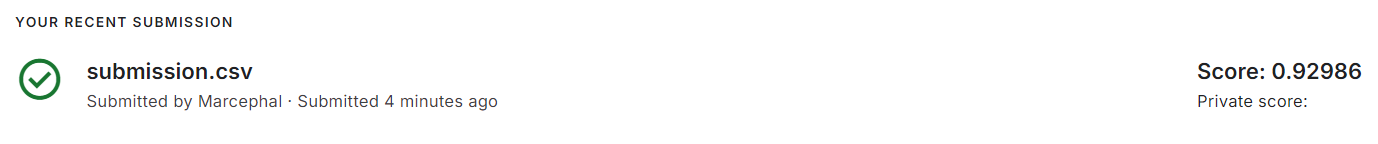